In [1]:
import pandas as pd
import numpy as np
import feather

from tqdm import tqdm

In [2]:
def evaluation_metric(y_true, y_pred):
    y_pred = y_pred.copy()
    y_pred[y_pred < 1.0] = 1.0
    y_pred = np.round(y_pred)
    scores = (y_pred - y_true) / (y_pred + y_true)
    scores[y_true < 1] = 0.0
    return np.abs(scores).mean()

In [3]:
df_base = feather.read_dataframe('features/base_features_no_outliers.feather')
df_mean_window = feather.read_dataframe('features/window_mean_features_noout.feather')
df_trend_window = feather.read_dataframe('features/window_trend_features_noout.feather')
df_week_trend = feather.read_dataframe('features/weekly_trends_features_noout.feather')
df_pc = feather.read_dataframe('features/pays_count_unmodified.feather')

In [4]:
common = (set(df_base.columns) & set(df_mean_window.columns))

In [5]:
for c in common:
    if not (df_base[c].fillna(-1) == df_mean_window[c].fillna(-1)).all():
        print('uwaga')
    if not (df_base[c].fillna(-1) == df_trend_window[c].fillna(-1)).all():
        print('uwaga')
    if not (df_base[c].fillna(-1) == df_week_trend[c].fillna(-1)).all():
        print('uwaga')
    if not (df_base[c].fillna(-1) == df_pc[c].fillna(-1)).all():
        print(c, 'uwaga')

pays_count uwaga


In [6]:
df_mean_window = df_mean_window[sorted(set(df_mean_window.columns) - common)]
df_trend_window = df_trend_window[sorted(set(df_trend_window.columns) - common)]
df_week_trend = df_week_trend[sorted(set(df_week_trend.columns) - common)]

In [7]:
df_features = pd.concat([df_base, df_mean_window, df_trend_window, df_week_trend], axis=1)
df_features['pays_count_unmodified'] = df_pc.pays_count_unmodified
df_features['penultimate_unmodified'] = df_pc.penultimate_unmodified

In [8]:
shops = df_features.shop_id.unique()
shops = sorted(shops)

In [9]:
df_train = df_features[df_features.biweek_id > 1].reset_index(drop=1)
df_val = df_features[df_features.biweek_id == 1].reset_index(drop=1)
df_test = df_features[df_features.biweek_id == 0].reset_index(drop=1)

In [10]:
len(df_train)

525010

In [11]:
df_train = df_train[~df_train.pays_count.isnull()].reset_index(drop=1)
df_val = df_val[~df_val.pays_count_unmodified.isnull()].reset_index(drop=1)

## Some stuff

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    y_pred = y_pred[~np.isnan(y)]
    y = y[~np.isnan(y)]

    y = y[~np.isnan(y_pred)]
    y_pred = y_pred[~np.isnan(y_pred)]

    return np.sqrt(mean_squared_error(y, y_pred))

In [14]:
y_train = df_train.pays_count.values
y_val = df_val.pays_count_unmodified.values

### Median trend features

In [15]:
trend_groups = [
    ('trend', ['trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_12', 'trend_18']),
    ('trend_dow', ['trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 
                   'trend_dow_12', 'trend_dow_18']),
    ('trend_weekend', ['trend_weekend_3', 'trend_weekend_4', 'trend_weekend_5',
                       'trend_weekend_6', 'trend_weekend_12', 'trend_weekend_18']),
]

In [16]:
for n, g in trend_groups:
    for df in [df_train, df_val, df_test]:
        df[n + '_median'] = df[g].median(axis=1)
        df[n + '_std'] = df[g].std(axis=1)

## Model

In [17]:
import xgboost as xgb

In [18]:
to_exclude = {
    'shop_id',
    'day', 'days_from_beginning', 'pays_count', 'week_id', 'biweek_id',
    'pays_count_unmodified', 'penultimate_unmodified'
}
features = sorted(set(df_train.columns) - to_exclude)
print(features)

['biweekly_coef', 'biweekly_dow_coef', 'biweekly_dow_trend', 'biweekly_trend', 'biweekly_weekend_coef', 'biweekly_weekend_trend', 'dow', 'dow_mean_12', 'dow_mean_2', 'dow_mean_3', 'dow_mean_4', 'dow_mean_5', 'dow_mean_6', 'dow_std_12', 'dow_std_2', 'dow_std_3', 'dow_std_4', 'dow_std_5', 'dow_std_6', 'is_weekend', 'mean_1', 'mean_12', 'mean_2', 'mean_3', 'mean_4', 'mean_5', 'mean_6', 'ooo_mean_1', 'ooo_mean_2', 'ooo_mean_3', 'ooo_mean_4', 'out_of_operation', 'pays_two_weeks_ago', 'penultimate', 'penultimate_null', 'second_in_biweek', 'std_1', 'std_12', 'std_2', 'std_3', 'std_4', 'std_5', 'std_6', 'trend_12', 'trend_18', 'trend_2', 'trend_3', 'trend_4', 'trend_5', 'trend_6', 'trend_coef_12', 'trend_coef_18', 'trend_coef_2', 'trend_coef_3', 'trend_coef_4', 'trend_coef_5', 'trend_coef_6', 'trend_dow_12', 'trend_dow_18', 'trend_dow_3', 'trend_dow_4', 'trend_dow_5', 'trend_dow_6', 'trend_dow_coef_12', 'trend_dow_coef_18', 'trend_dow_coef_3', 'trend_dow_coef_4', 'trend_dow_coef_5', 'trend_dow

In [19]:
X_train = df_train[features].values
X_val = df_val[features].values

In [20]:
def eval_metric(preds, dtrain):
    y_true = dtrain.get_label()
    return 'metric', evaluation_metric(y_true, preds)

In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features, missing=np.nan)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features, missing=np.nan)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [22]:
xgb_pars = {
    'eta': 0.1,
    'gamma': 0,
    'max_depth': 8,
    'min_child_weight': 1,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'lambda': 1,
    'alpha': 0,
    'tree_method': 'approx',
    'objective': 'reg:linear',
    #'objective': 'count:poisson',
    'eval_metric': 'rmse',
    'nthread': 8,
    'seed': 42,
    'silent': 1
}

In [23]:
n_estimators = 80

In [24]:
model = xgb.train(xgb_pars, dtrain, num_boost_round=n_estimators, verbose_eval=5, 
                  evals=watchlist, feval=eval_metric)

[0]	train-rmse:156.833	val-rmse:190.841	train-metric:0.788842	val-metric:0.798445
[5]	train-rmse:100.518	val-rmse:126.778	train-metric:0.342685	val-metric:0.346112
[10]	train-rmse:69.5775	val-rmse:92.9427	train-metric:0.194667	val-metric:0.187896
[15]	train-rmse:53.7689	val-rmse:75.6542	train-metric:0.140614	val-metric:0.129817
[20]	train-rmse:46.0385	val-rmse:67.3311	train-metric:0.121506	val-metric:0.109892
[25]	train-rmse:42.1675	val-rmse:64.0155	train-metric:0.114871	val-metric:0.10334
[30]	train-rmse:39.9237	val-rmse:61.7121	train-metric:0.112393	val-metric:0.101175
[35]	train-rmse:38.6861	val-rmse:60.9528	train-metric:0.111369	val-metric:0.1005
[40]	train-rmse:37.5836	val-rmse:61.011	train-metric:0.110789	val-metric:0.100229
[45]	train-rmse:36.9628	val-rmse:61.2557	train-metric:0.110517	val-metric:0.100205
[50]	train-rmse:36.4846	val-rmse:61.586	train-metric:0.110273	val-metric:0.100136
[55]	train-rmse:35.9895	val-rmse:61.8063	train-metric:0.110205	val-metric:0.100218
[60]	train-

In [25]:
y_pred = model.predict(dval)
evaluation_metric(y_val, y_pred)

0.10013925680118055

In [26]:
rmse(y_val, y_pred)

62.455900503814014

In [27]:
df_val['pred'] = np.round(y_pred)

In [28]:
scores = model.get_score(importance_type='gain')
sorted(scores.items(), key=lambda x: -x[1])

[('trend_weekend_median', 147237914.0433333),
 ('trend_dow_median', 96918043.18243282),
 ('dow_std_12', 8373928.30963115),
 ('trend_overall_dow', 7489301.011446153),
 ('trend_weekend_coef_18', 4499246.953636364),
 ('trend_weekend_6', 1960595.5648110239),
 ('biweekly_weekend_coef', 1908431.604785185),
 ('trend_weekend_coef_12', 1600441.9012977101),
 ('biweekly_dow_trend', 1463254.2826232512),
 ('trend_coef_12', 1367831.510114286),
 ('trend_dow_18', 1248345.9398168495),
 ('trend_dow_6', 1028232.0170955891),
 ('penultimate', 951665.8941835256),
 ('ooo_mean_4', 926801.6622080005),
 ('trend_dow_12', 915797.7932907341),
 ('trend_coef_3', 893282.8000000002),
 ('dow_mean_12', 883914.8857142861),
 ('dow_std_2', 778182.2368987341),
 ('trend_overall_coeff', 774487.2727272725),
 ('trend_coef_5', 765485.8131100481),
 ('trend_coef_4', 741322.5240291258),
 ('trend_weekend_coef_3', 734476.8209790211),
 ('trend_overall_weekend_coeff', 688246.0243589745),
 ('dow_mean_3', 612255.461932773),
 ('trend_2', 

In [35]:
set(features) - scores.keys()

{'is_weekend',
 'mean_12',
 'mean_2',
 'mean_3',
 'mean_4',
 'mean_5',
 'mean_6',
 'out_of_operation',
 'penultimate_null',
 'std_12',
 'std_2',
 'std_3',
 'std_4',
 'std_5',
 'std_6',
 'weekend_mean_12',
 'weekend_mean_2',
 'weekend_mean_3',
 'weekend_mean_4',
 'weekend_mean_5',
 'weekend_mean_6',
 'weekend_std_12',
 'weekend_std_2',
 'weekend_std_3',
 'weekend_std_4',
 'weekend_std_5',
 'weekend_std_6'}

In [30]:
nom = (df_val.pays_count_unmodified - df_val.pred).abs()
denom = (df_val.pays_count_unmodified + df_val.pred)
df_val['score'] = nom / denom

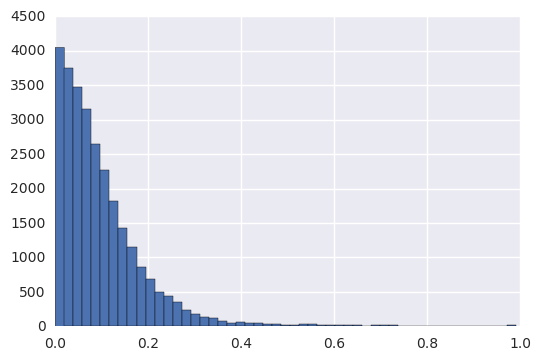

In [31]:
df_val.score.hist(bins=51)

In [32]:
val_mean_score = df_val.groupby('shop_id').score.mean()
val_mean_score.sort_values(ascending=False)

shop_id
810     0.859152
1556    0.732299
1918    0.730967
731     0.566994
1464    0.541632
1548    0.516754
742     0.500438
474     0.457529
23      0.455818
1747    0.425345
1526    0.410194
632     0.400937
459     0.388744
727     0.386010
1214    0.382350
1843    0.361151
524     0.346781
561     0.343351
530     0.329794
1100    0.321051
1384    0.320399
619     0.316677
1426    0.314295
1107    0.309489
1561    0.308740
1968    0.307536
1218    0.306449
1875    0.304210
1856    0.303355
1510    0.297581
          ...   
1648    0.036571
318     0.036227
346     0.036171
226     0.035814
1413    0.035674
1400    0.035439
1778    0.035353
1624    0.035151
1392    0.034857
1807    0.034612
1025    0.034360
17      0.034183
102     0.033787
293     0.033582
1355    0.032517
1181    0.032205
1117    0.031977
820     0.031693
362     0.031555
884     0.031551
54      0.031040
909     0.030840
1976    0.030276
100     0.030084
516     0.029394
1901    0.028120
1874    0.023896
713   

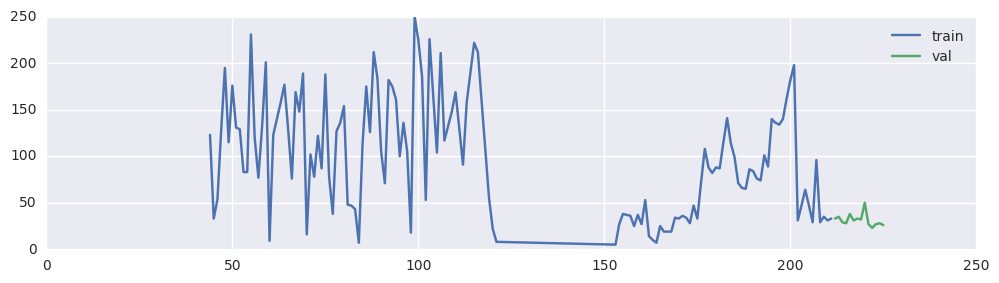

In [43]:
shop_id = 1548
df_shop_train = df_train[df_train.shop_id == shop_id]
df_shop_val = df_val[df_val.shop_id == shop_id]

plt.figure(figsize=(12, 3))
plt.plot(df_shop_train.days_from_beginning, df_shop_train.pays_count, label='train')

plt.plot(df_shop_val.days_from_beginning, df_shop_val.pays_count_unmodified, label='val')
#plt.plot(df_shop_val.days_from_beginning, df_shop_val.pred, label='pred')
plt.legend()
plt.show()

In [34]:
evaluation_metric(y_val, df_val.penultimate_unmodified)

0.09024919457575448

In [98]:
X_test = df_test[features].values
dtest = xgb.DMatrix(X_test, feature_names=features, missing=np.nan)

In [103]:
y_pred = model.predict(dtest)
y_pred[y_pred < 1] = 1
y_pred = np.round(y_pred).astype(int)
df_test['pred'] = y_pred

In [104]:
shops = sorted(set(df_test.shop_id))

In [107]:
with open('sub.csv', 'w') as f:
    for i in tqdm(shops):
        df_shop = df_test[df_test.shop_id == i]
        f.write(str(i) + ',')
        f.write(','.join(str(d) for d in df_shop.pred))
        f.write('\n')

100%|██████████| 2000/2000 [00:01<00:00, 1258.09it/s]


In [108]:
!head sub.csv

1,232,206,218,236,253,241,206,241,212,221,245,260,242,226
2,87,94,89,95,113,108,85,88,96,92,97,114,104,86
3,76,76,76,81,98,97,76,77,77,77,81,98,98,77
4,97,101,97,104,165,165,100,97,101,95,103,167,167,99
5,254,194,236,220,222,242,293,276,197,227,219,225,242,308
6,94,94,100,103,103,98,92,98,94,98,104,102,94,92
7,130,122,121,132,162,169,120,133,122,122,132,166,175,123
8,57,55,55,54,71,71,52,57,53,55,53,72,70,52
9,229,229,228,237,273,280,231,233,234,232,242,272,278,236
10,93,99,94,95,96,97,102,95,102,98,100,101,100,104
